# Damage Library

This module provides a computational framework for constructing degrading models inspired by the hypothesis of @kachanov1958vremeni. A survey of the resulting theory is given by @krajcinovic1995continuum.


The complete implementation follows the approach described by @ngoc2017damage.
A notable implementation of a similar model is the `*CONCRETE DAMAGED PLASTICITY` model provided by the program ABAQUS, and based on the work of @lee1998plasticdamage.

The core concept is to take an existing *basis* model for a work-conjugate pair of variables, and construct a new model which progressively deteriorates the response of the basis model.

In the univariate case, it is postulated that degredation takes the form

$$
\begin{aligned}
\sigma &= (1 - d) \bar{\sigma} \\
E &= (1 - d) \bar{E}
\end{aligned}
$$


The internal variable, $d$, varies from $0$ to $1$ and evolves according to a *dissipation* rule that is defined by assigning an *accumulation* relation over an energy 
interval, $\{\psi_{d0}, \psi_{d1}\}$.

In [1]:
from damage import (
    # Submodules
    accumulation,
    dissipation ,
    # Wrapper
    FedeasUnivariateDamage
)
from opensees import uniaxial
from opensees.tcl import dumps

In [2]:
from opensees.units.english import ksi, psi, inch, ft
from numpy import sin, linspace, pi, sqrt

In [3]:
import matplotlib.pyplot as plt
plt.style.use("typewriter")

### Accumulation Rules

The `accumulation` submodule is a library of accumulation models. An accumulation object
has the following methods:

- ```.py
  AccumulationModel.getIndex(psi: float) -> DamageIndex
  ```
  where `DamageIndex` has scalar fields `y` and `dydx` containing the value and
  tangent, respectively, of the accumulation function at the given normalized
  energy, `psy`.

>**NOTE** This design uses a single method to return both the value and tangent
of the accumulation model. It may be preferable to change this for consistency with
the OpenSees style, where models have distinct `getResponse` and `getTangent` methods.



In [4]:
psi = linspace(0.00, 1., 100)

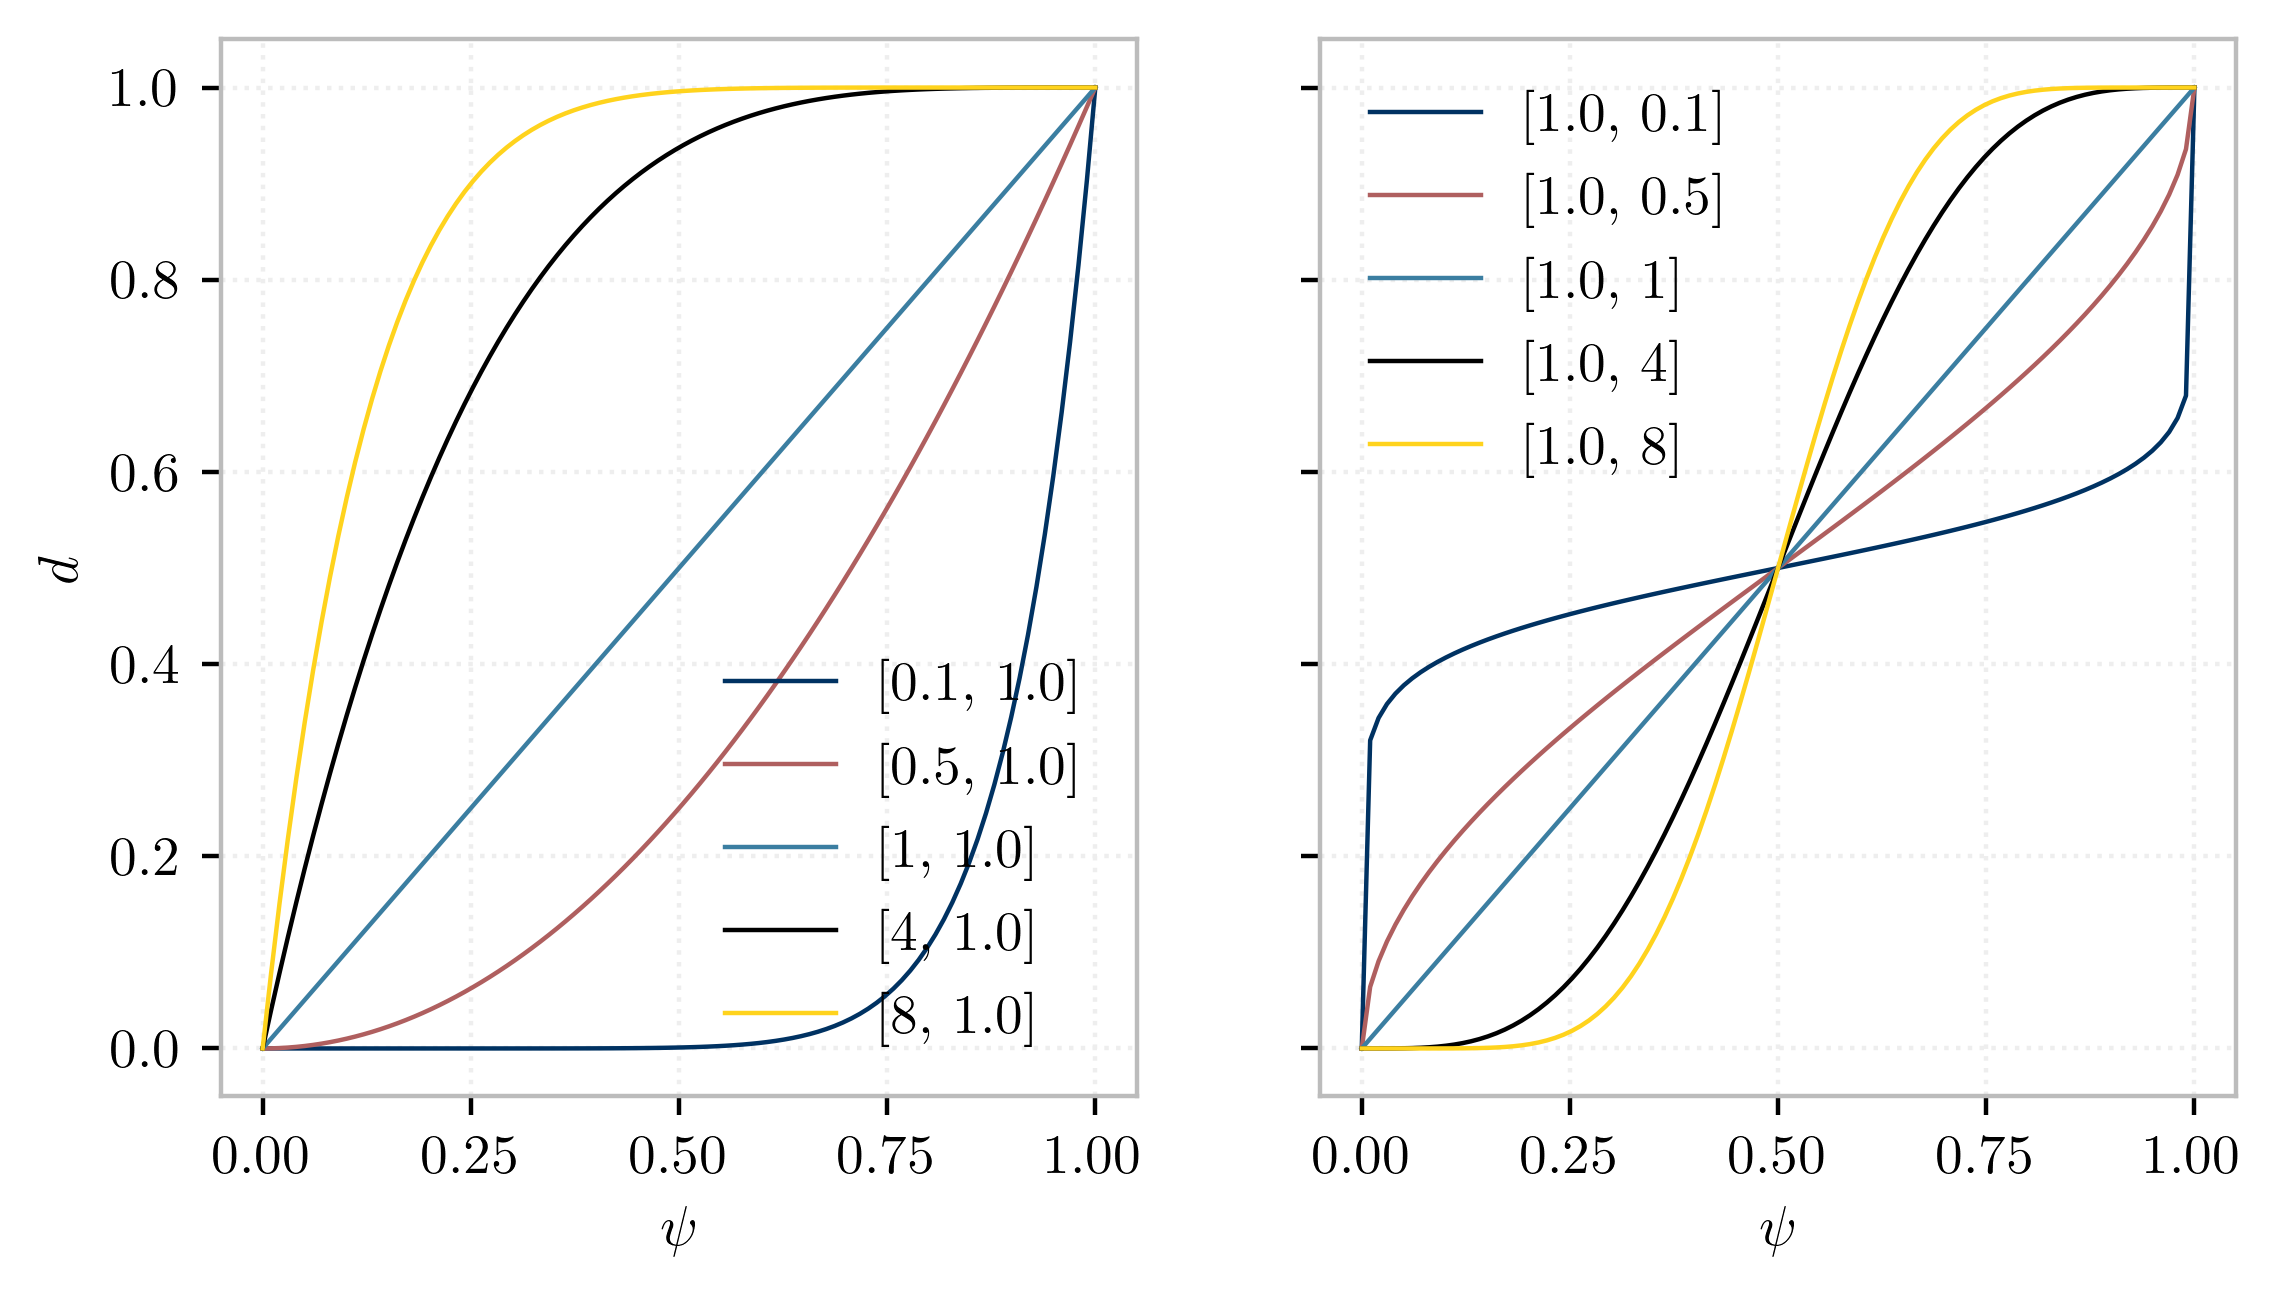

In [5]:
fig, axs = plt.subplots(1,2, figsize=(6.5,3.5),  sharey=True)

parameter_range = [0.1, 0.5, 1, 4, 8]
parameters = [None, None]

for i,ax in enumerate(axs):
    for param in parameter_range:
        parameters[i] = param
        parameters[not i] = 1.0
        a = accumulation.MBeta(None, parameters)
        ax.plot(psi, [a.getIndex(x).y for x in psi], label=f"{parameters}")
    ax.legend()
    # ax.axis("equal")
    ax.set_xlabel(r"$\psi$")
axs[0].set_ylabel(r"$d$");

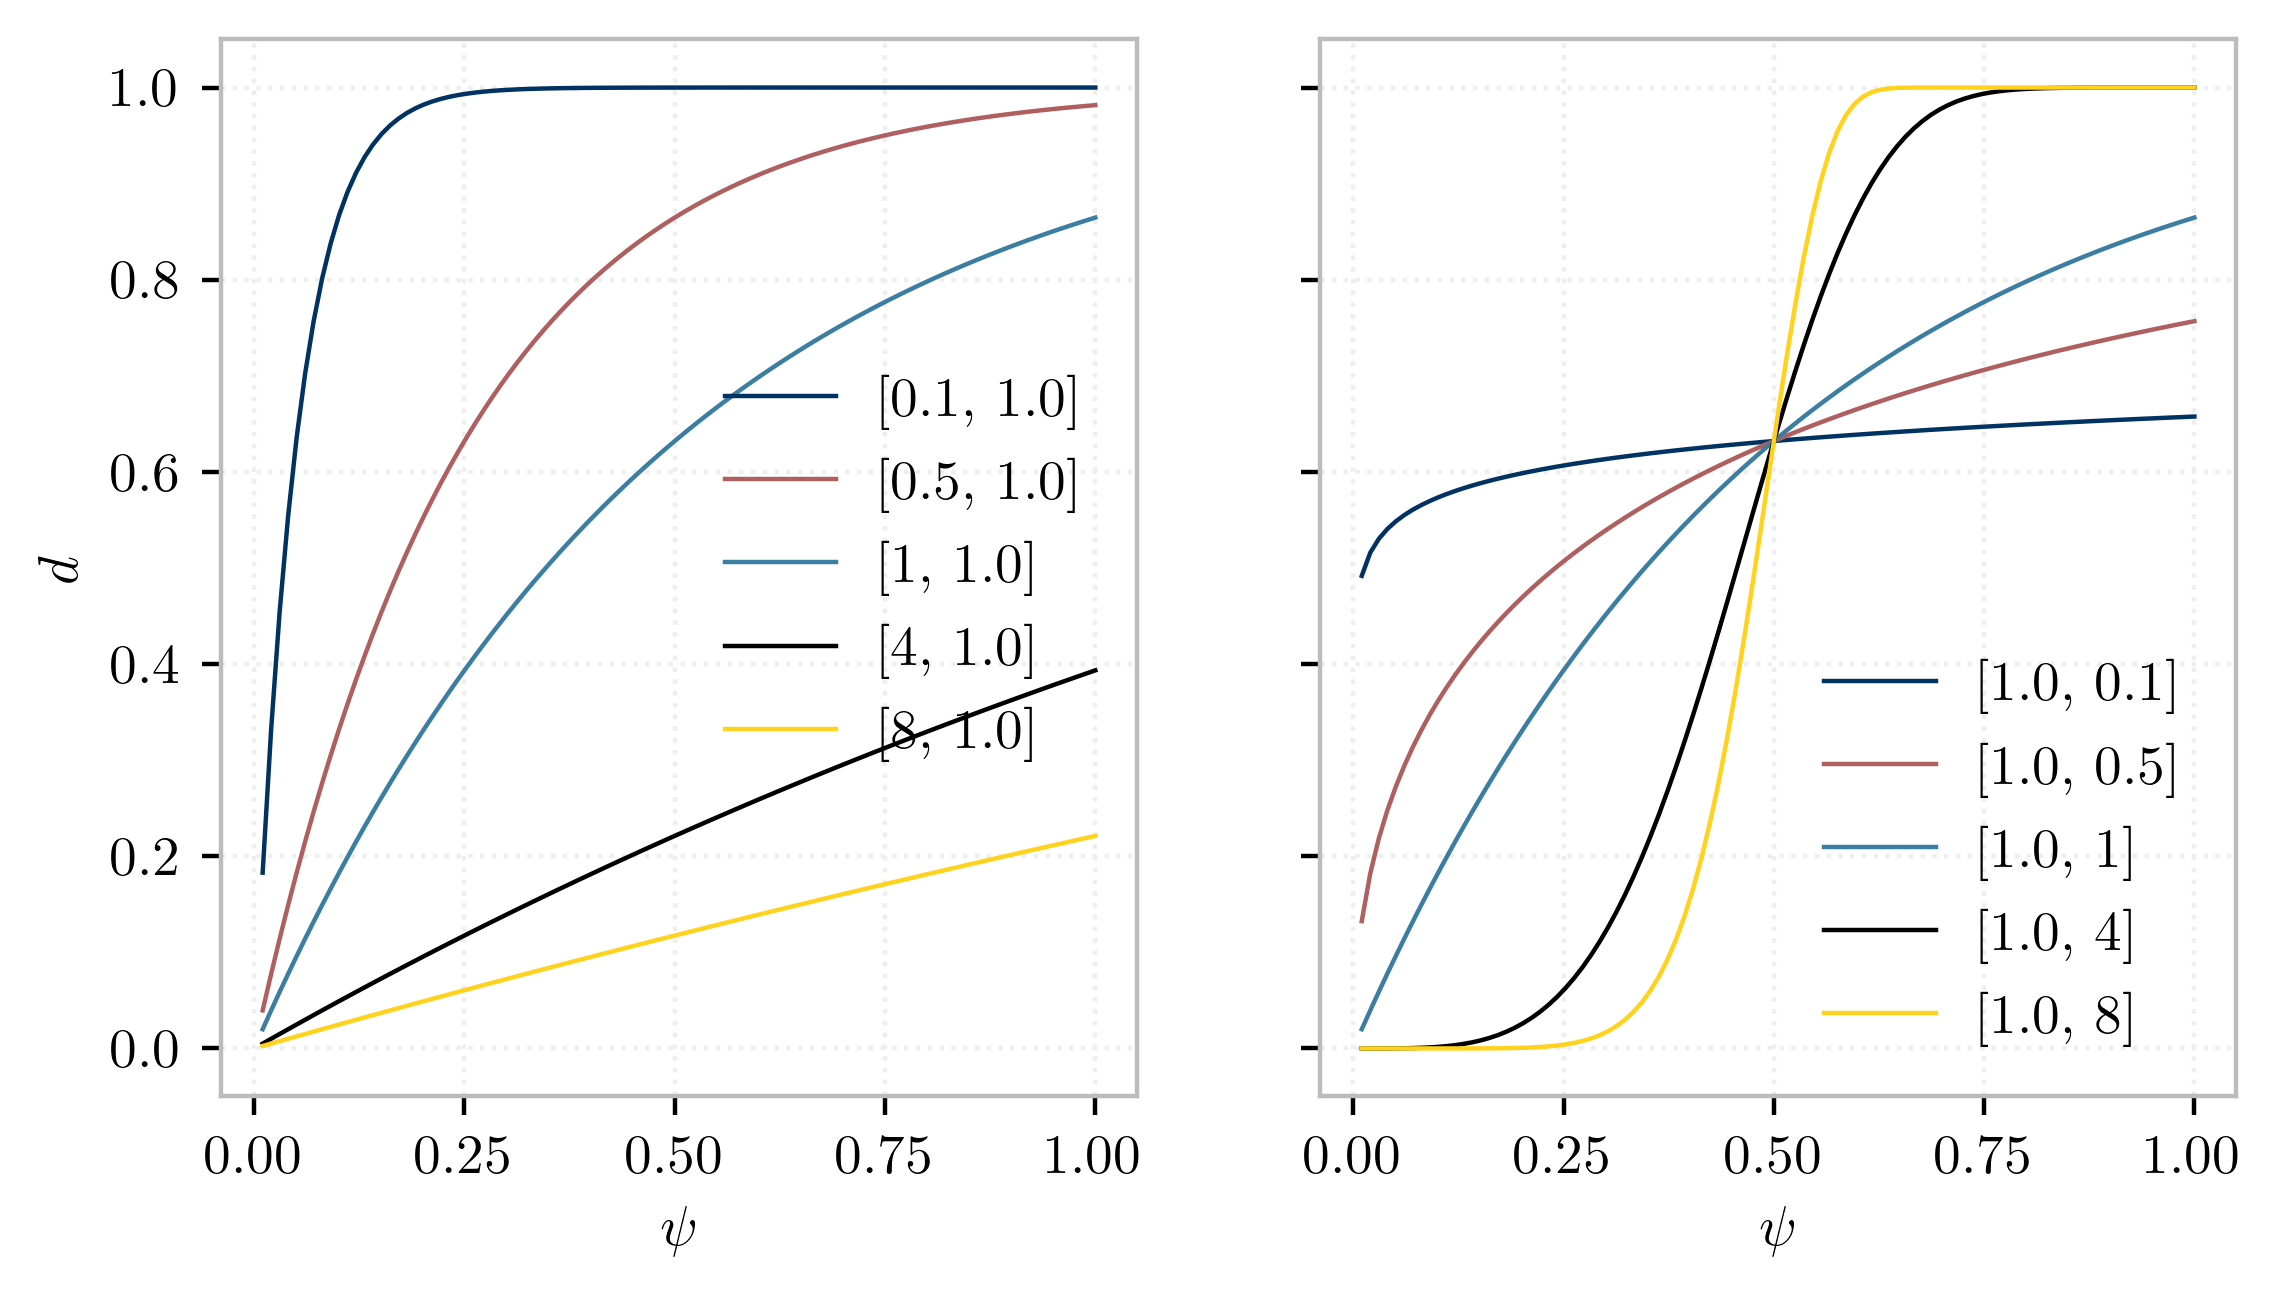

In [6]:
#????????????????????????????????
fig, axs = plt.subplots(1,2, figsize=(6.5,3.5),  sharey=True)

parameter_range = [0.1, 0.5, 1, 4, 8]
parameters = [None, None]

for i,ax in enumerate(axs):
    for param in parameter_range:
        parameters[i] = param
        parameters[not i] = 1.0
        a = accumulation.Weibull(None, parameters)
        ax.plot(psi, [a.getIndex(2*x).y for x in psi], label=f"{parameters}")
    ax.legend()
    # ax.axis("equal")
    ax.set_xlabel(r"$\psi$")
axs[0].set_ylabel(r"$d$");

### Dissipation

The `TotalStrain` dissipation rule specifies the maner in which energy is dissipated for a particular loading direction. This allows distinct strategies to be applied in tension and compression.

A directional dissipation rule can be defined in the following ways:

- `TotalStrain(accum, interval, cycle, scale)`




In [7]:
interval  = [3, 125]  # [Cd0, Cd1]
cycle     =  0.0   # Cwc
scale     = {"E": 29e6, "fy": 60e3}

In [8]:
# Directional Coupling
coupling  = [0.1, 0.1]    # Ccd

In [9]:
Fy  = 66.8*ksi             # steel yield stress
Es  = 29000.*ksi           # modulus of steel
Bs  = 0.04                 # strain-hardening ratio 
R0  = 20                   # control the transition from elastic to plastic branches
cR1 = 0.925                # "
cR2 = 0.15                 # "

In [10]:
steel = uniaxial.Steel02(None, 60e3, 29e6, 0.05, R0=R0)

In [11]:
a = accumulation.MBeta(1, [4.2, 1.])
d = dissipation.TotalStrain(a, interval, cycle, scale)
m = FedeasUnivariateDamage(2, steel,  d, 0.0)

uniaxialMaterial Steel02 1  60000.0  29000000.0  0.05  20  0.925  0.15 
import  /home/claudio/packages/libdmg/bin/libdmg.so 
dmg::evol mbeta 1   4.2  1.0 
dmg::load Uni 1 -evol 1 -Cd0 3 -Cd1 125 -Cwc 0.0 -E 29000000.0 -fy 60000.0 
dmg::evol mbeta 2   4.2  1.0 
dmg::load Uni 2 -evol 2 -Cd0 3 -Cd1 125 -Cwc 0.0 -E 29000000.0 -fy 60000.0 
dmg::wrap 1d 2  1  2 -Ccd 0.0 
uniaxialMaterial FedeasUniaxialDamage 2  1 -damage 2 



#libdmg::Debug -- libdmg version '0.0.1' successfully loaded.
#libdmg::Debug -- new 'mbeta' damage evolution with tag '1', dp=[4.200000, 1.000000, ]
#libdmg::Debug -- new damage loading with tag '1'
#libdmg::Debug -- new 'mbeta' damage evolution with tag '2', dp=[4.200000, 1.000000, ]
#libdmg::Debug -- new damage loading with tag '2'
#libdmg::Debug -- creating uniaxial wrapper
#libdmg::Debug -- new '1d' damage wrapper with tag '2' at '0x559fee51bf60'
#libdmg::Debug -- found map of tagged wrappers.
#Set damage wrapper '2'


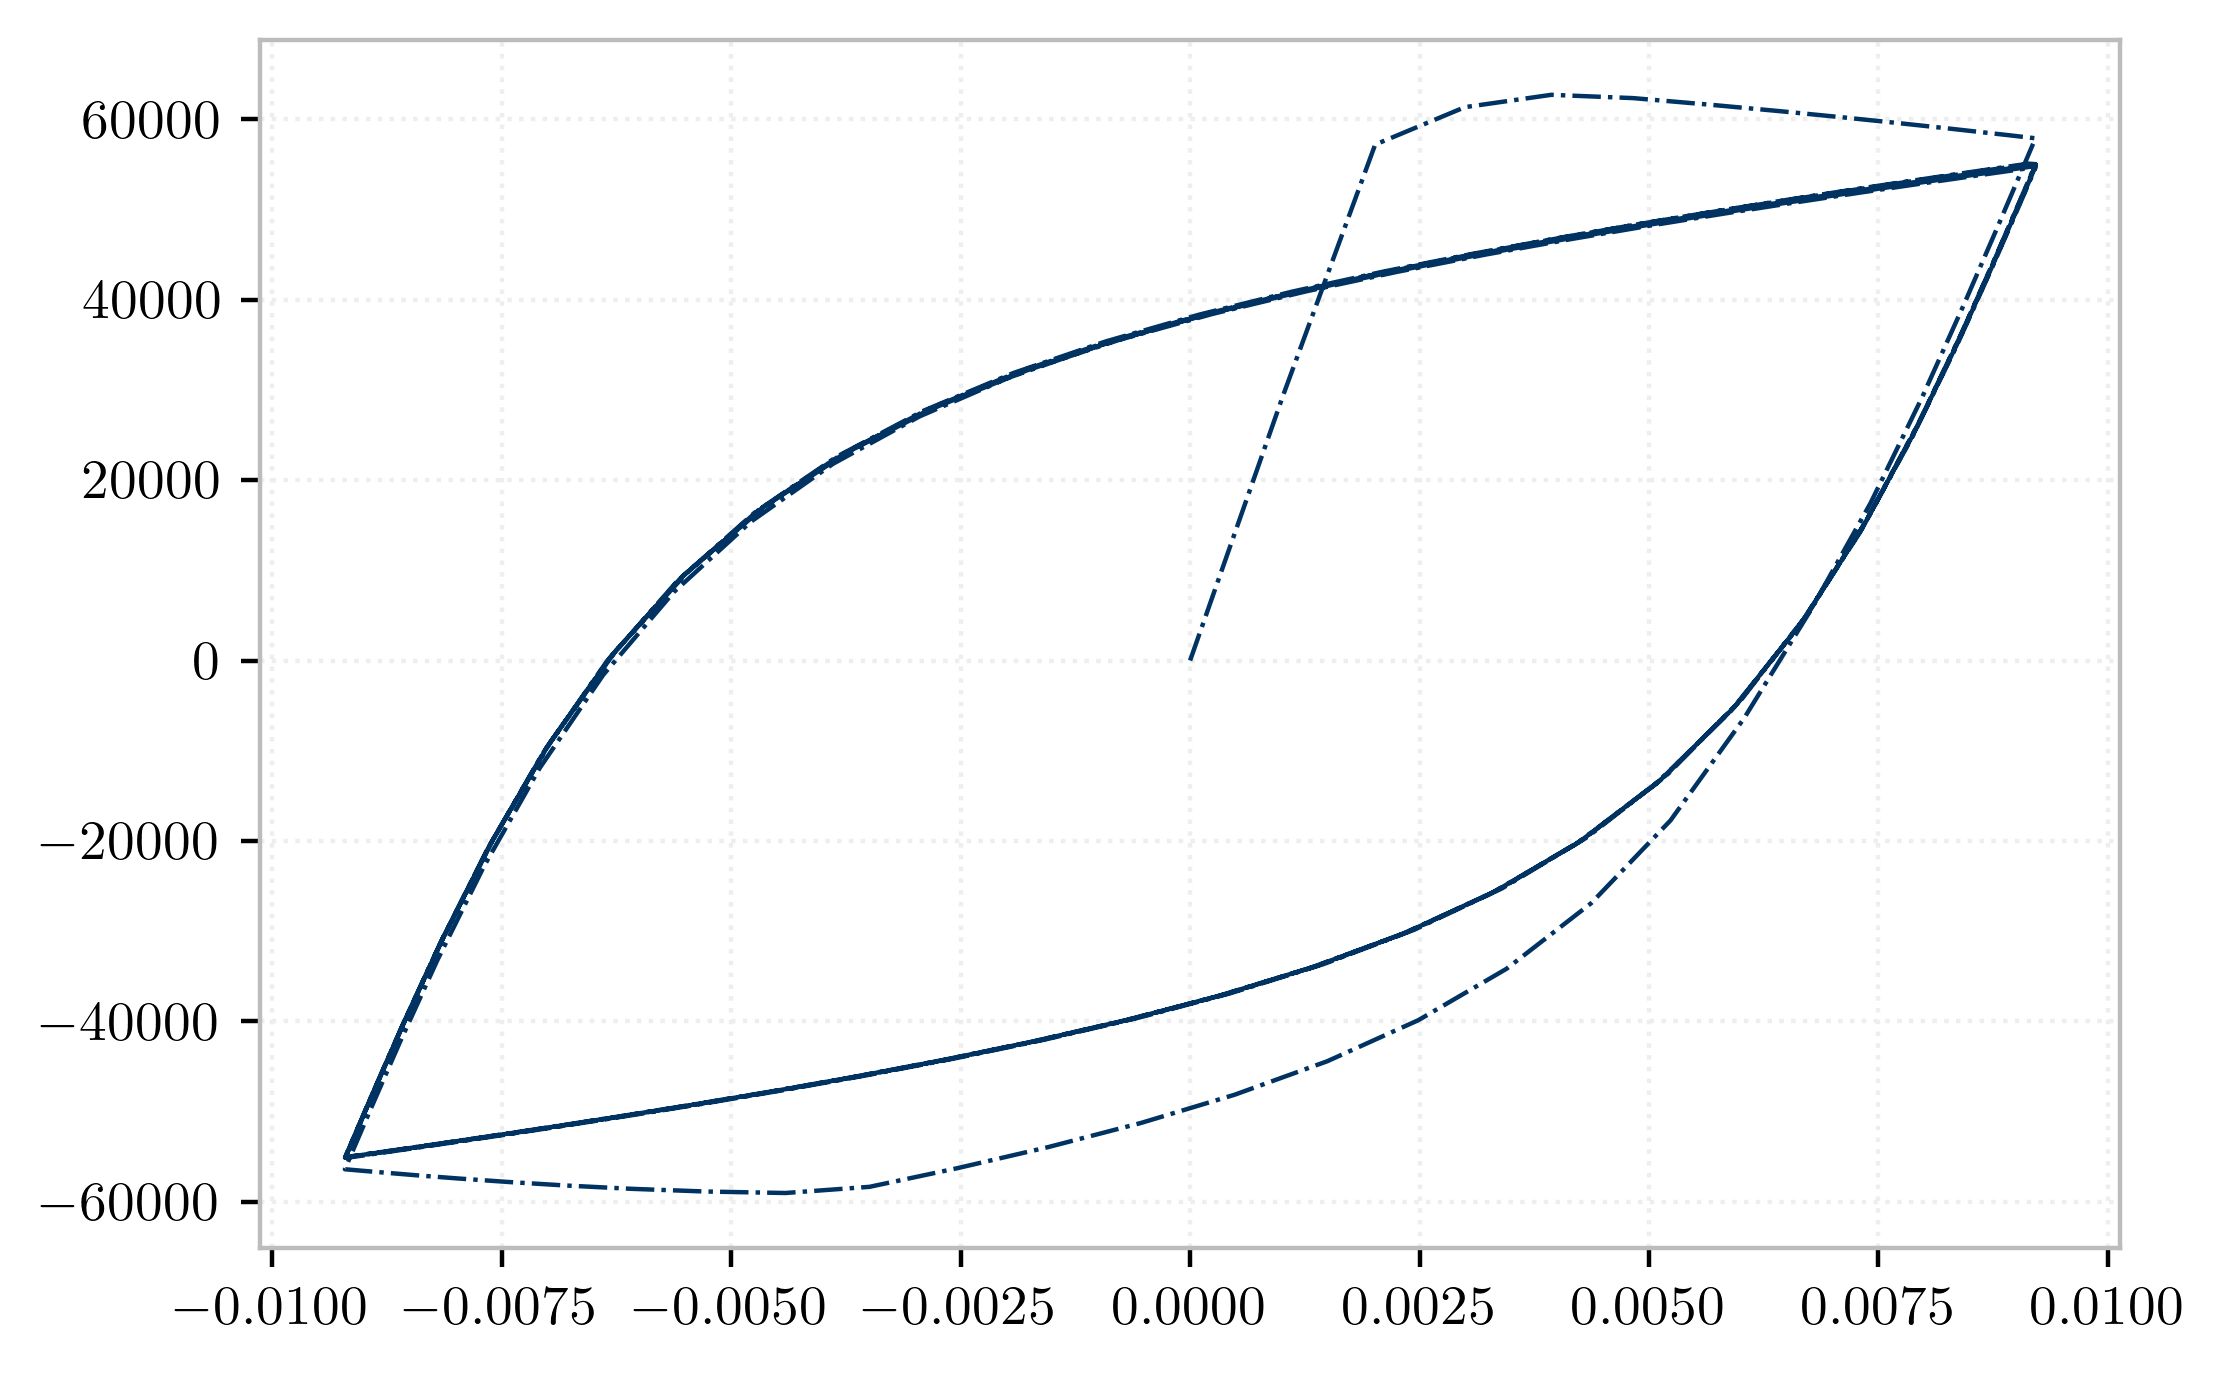

In [12]:
print(dumps(m))

n = 300
strain = 4.*Fy/Es*sin(linspace(0, 10.5*pi, n))#*linspace(0.2, 8.0, n)
with m as mat:
    plt.plot(strain, [mat.getStress(e, commit=True) for e in strain],"-.")

## Examples

In [13]:
a = accumulation.MBeta(1, [4.2, 1.])
d = dissipation.TotalStrain(a, interval, cycle, scale)

#libdmg::Debug -- libdmg version '0.0.1' successfully loaded.
#libdmg::Debug -- new 'mbeta' damage evolution with tag '1', dp=[4.200000, 1.000000, ]
#libdmg::Debug -- new damage loading with tag '1'
#libdmg::Debug -- new 'mbeta' damage evolution with tag '2', dp=[4.200000, 1.000000, ]
#libdmg::Debug -- new damage loading with tag '2'
#libdmg::Debug -- creating uniaxial wrapper
#libdmg::Debug -- new '1d' damage wrapper with tag '1' at '0x559fefb74080'
#libdmg::Debug -- found map of tagged wrappers.
#Set damage wrapper '1'
#libdmg::Debug -- libdmg version '0.0.1' successfully loaded.
#libdmg::Debug -- new 'mbeta' damage evolution with tag '1', dp=[4.200000, 1.000000, ]
#libdmg::Debug -- new damage loading with tag '1'
#libdmg::Debug -- new 'mbeta' damage evolution with tag '2', dp=[4.200000, 1.000000, ]
#libdmg::Debug -- new damage loading with tag '2'
#libdmg::Debug -- creating uniaxial wrapper
#libdmg::Debug -- new '1d' damage wrapper with tag '1' at '0x559fefb712c0'
#libdmg::Debug -- 

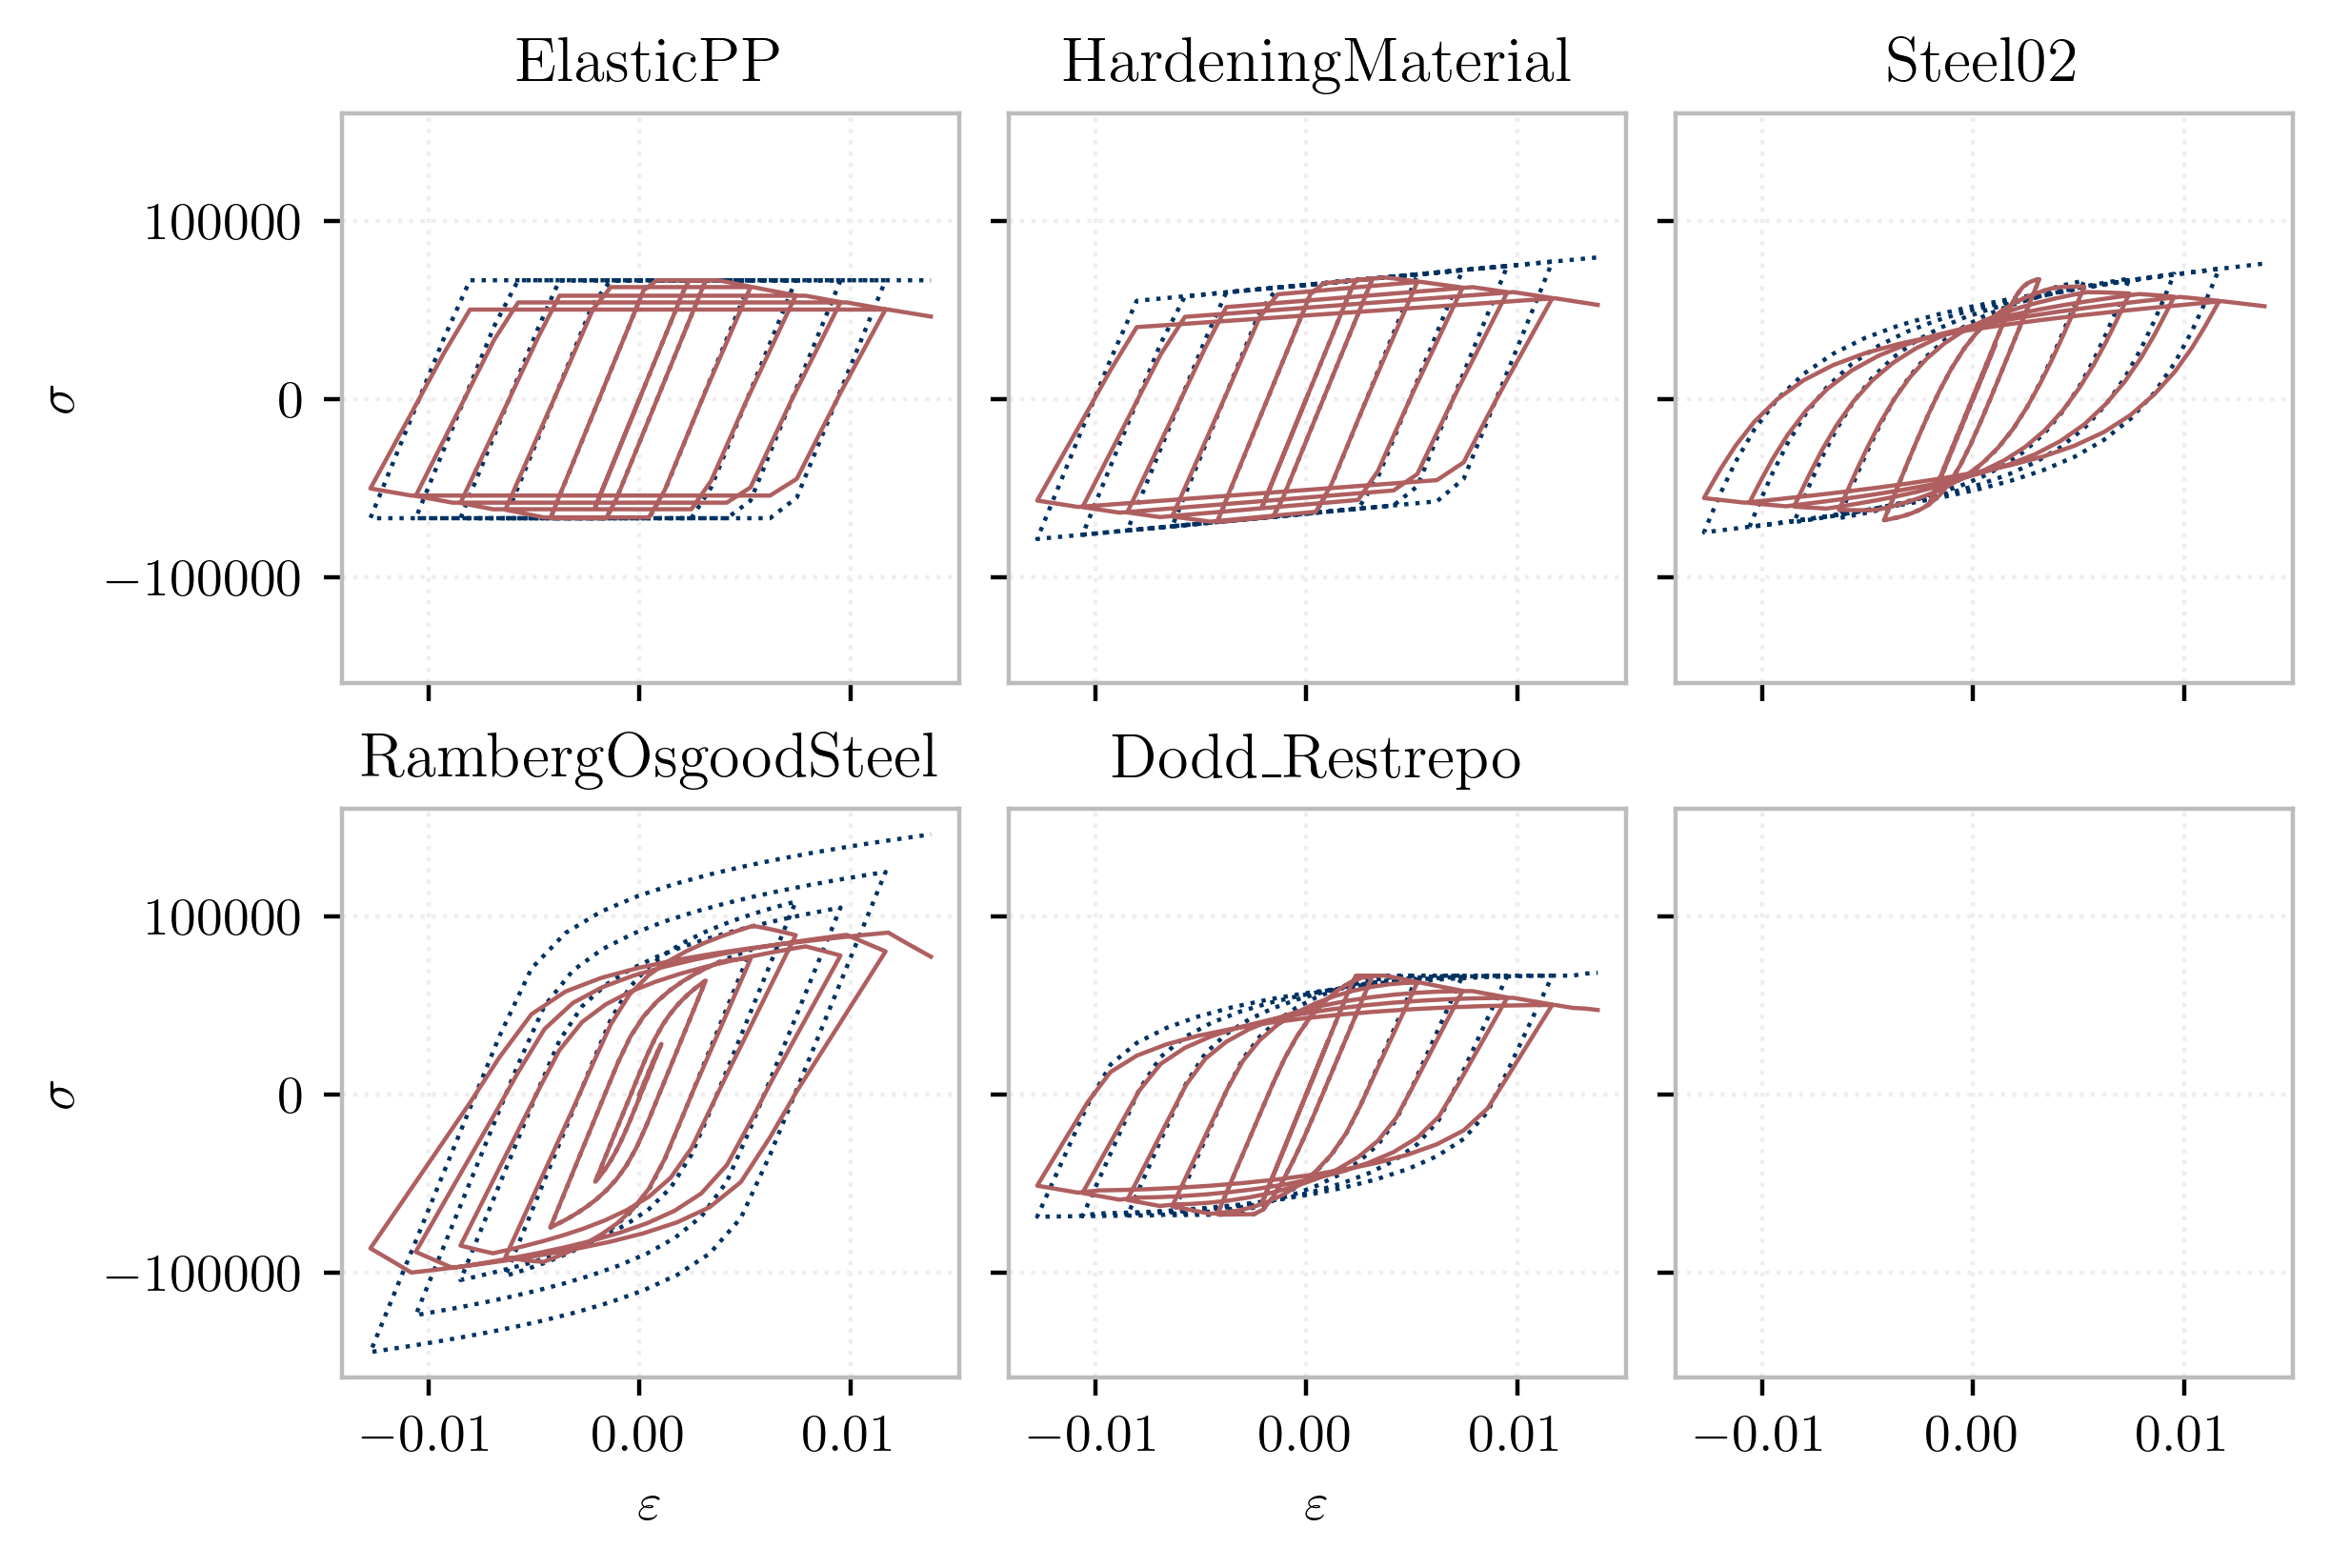

In [14]:
n = 300
strain = Fy/Es*sin(linspace(0, 12.5*pi, n))*linspace(0.2, 6.0, n)

fig, ax = plt.subplots(2,3, sharey=True, sharex=True, constrained_layout=True)

esh, esu = 10*Fy/Es, 14*Fy/Es
eshi = (esu + 5*esh)/5

materials = [
    uniaxial.ElasticPP(None, Es, Fy/Es),
    uniaxial.Hardening(None, Es, Fy, 0.00*Es, 0.04*Es),
    uniaxial.Steel02(None, Fy, Es, Bs, 18.),
    uniaxial.RambergOsgoodSteel(None, Fy, Es, 0.002, 4),
    uniaxial.DoddRestrepo(None, Fy, 1.3*Fy, esh, esu, Es, eshi, 1.1*Fy),
]

for i,base in enumerate(materials):
    with base as m:
        ax[i//3, i%3].plot(strain, [m.getStress(e, commit=True) for e in strain], ":", label="base")
        ax[i//3, i%3].set_title(base.__class__.__name__)

    with FedeasUnivariateDamage(2, base, d, 0.05) as m:
        ax[i//3, i%3].plot(strain, [m.getStress(e, commit=True) for e in strain])

    if not i%3:
        ax[i//3, i%3].set_ylabel(r"$\sigma$")
    if i//3:
        ax[i//3, i%3].set_xlabel(r"$\varepsilon$")

## Python Material

In [15]:
from jax.numpy import linspace, logspace, sin, cos, pi, sign

In [16]:
import opensees
from opensees import tcl
m = opensees.model(ndm=2,ndf=3)
tcl.TclRuntime().model(m)
from opensees import libOpenSeesRT

class UniaxialMaterial(libOpenSeesRT._UniaxialMaterial):
    def __enter__(self):
        self.stress = 0.0
        self.strain = 0.0
        self.revertToStart()
        return self
    
    def __exit__(self, *args, **kwds):
        self.revertToStart()
    
    def getCopy(self):
        return self

In [17]:
from scipy.integrate import solve_ivp

class BoucWenBaber(UniaxialMaterial):
    "Bouc, Wen and Baber model from Baber and Wen 1981"
    def __init__(self, name, A0, 𝛾, β, n, k0=0, n1=0, n2=0, n3=0):
        self.parameters = A0, 𝛾, β, n, k0, n1, n2, n3
        self.name = str(name)
        self.revertToStart()
        UniaxialMaterial.__init__(self, int(self.name))
    
    def revertToStart(self):
        self.state = [0., 0.]
        self.strain = 0.0
        self.stress = 0.0
        self.tangent = 0.0
        return 0

    def getStress(self, *args, **kwds):
        if len(args) > 0:
            self.setTrialStrain(args[0])
            if "commit" in kwds:
                self.commitState()
        return self.stress
    
    def getStrain(self):
        return self.strain

    def getTangent(self):
        return self.tangent

    def getInitialTangent(self):
        return self.tangent

    def getDampTangent(self):
        return self.tangent
         
    def commitState(self): return 0

    def setTrialStrain(self, ε, *args, **kwds):
        ε0 = self.strain
        z0, e0 = self.state
        A0, 𝛾, β, n, k0, n1, n2, n3 = self.parameters

        dε = ε - ε0
        def f(ε, y):
            # Damage history variables
            A_  = A0 - n1*y[1]
            nu  =  1 + n2*y[1]
            eta =  1 + n3*y[1]
            dz  = (A_ - nu*(β*sign(dε*y[0]) + 𝛾)*abs(y[0])**n)/eta
            de  = k0*y[0]
            return [dz, de]

        soln = solve_ivp(f, (ε - dε, ε), [z0, e0])
        if soln.success:
            self.strain += dε
            self.state = soln.y[:,-1].T
            self.stress = soln.y[0,-1]
        else:
            raise ValueError("Failed to solve Bouc-Wen IVP.")

        return 0

#libdmg::Debug -- libdmg version '0.0.1' successfully loaded.
#libdmg::Debug -- new 'mbeta' damage evolution with tag '1', dp=[4.200000, 1.000000, ]
#libdmg::Debug -- new damage loading with tag '1'
#libdmg::Debug -- new 'mbeta' damage evolution with tag '2', dp=[4.200000, 1.000000, ]
#libdmg::Debug -- new damage loading with tag '2'
#libdmg::Debug -- creating uniaxial wrapper
#libdmg::Debug -- new '1d' damage wrapper with tag '1' at '0x559ff18aa3a0'
#libdmg::Debug -- found map of tagged wrappers.
#Set damage wrapper '1'


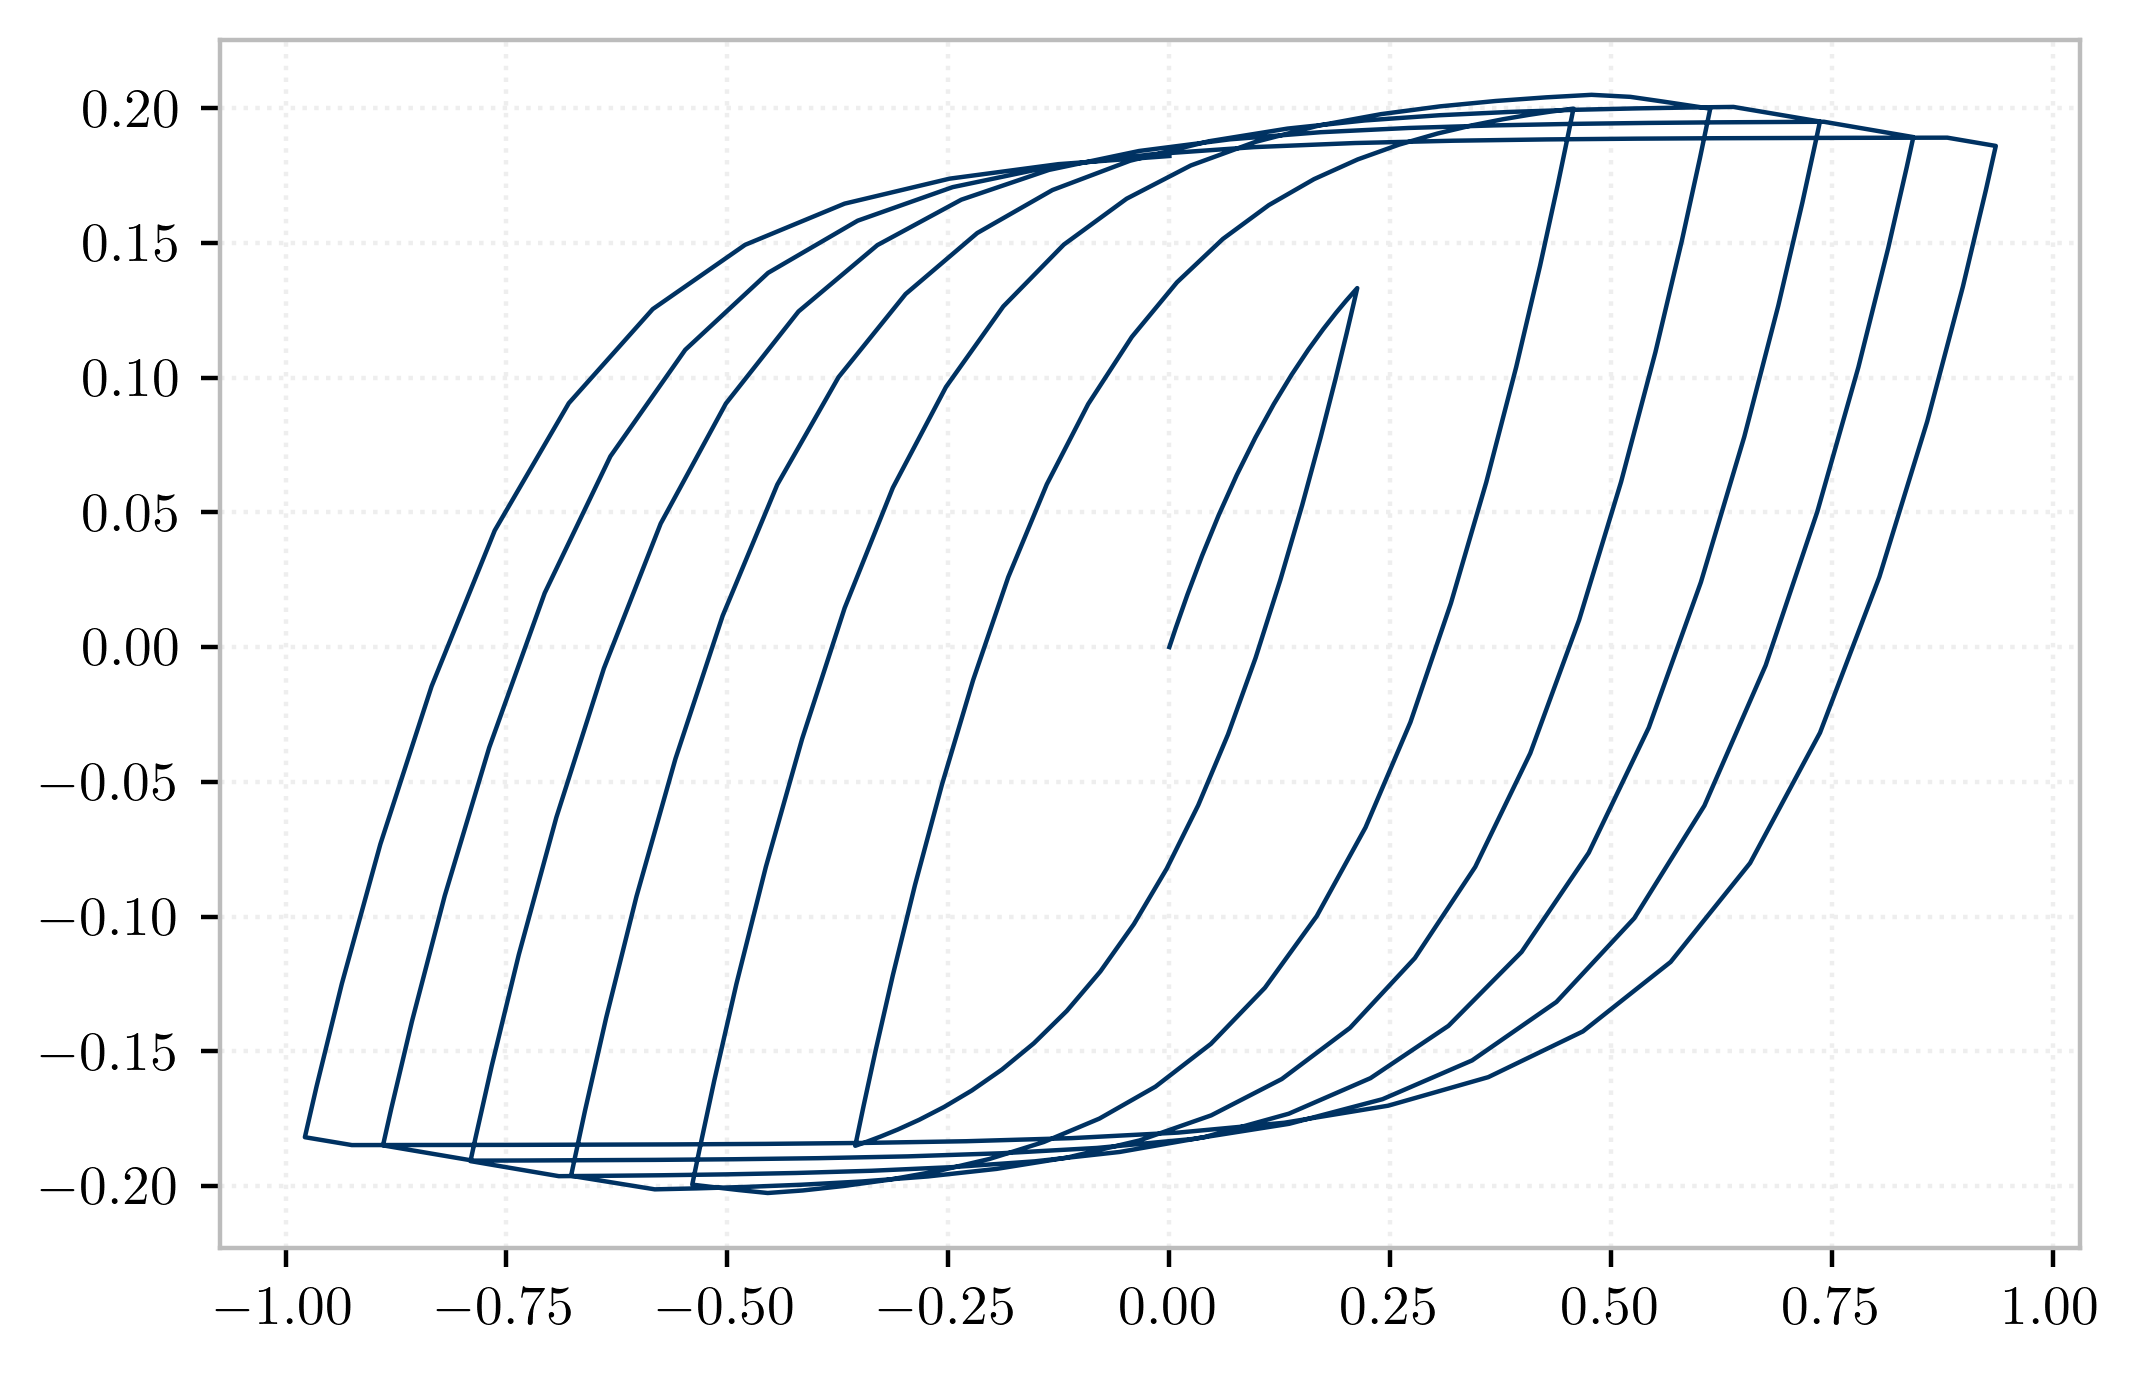

In [18]:
strain = sin(linspace(0, 12*pi, 300))*linspace(0, 1., 300)**0.5
hysteresis = BoucWenBaber(1, 1.0, β = 4.0, 𝛾 = 0.8, n=1.0, k0=10.0)
hysteresis_damage = BoucWenBaber(1, 1.0, β = 4.0, 𝛾 = 0.8, n=1.0, k0=10.0, n1=0.01)

dissipate = dissipation.TotalStrain(
    a, interval, cycle, {"fy": 0.7, "E": 10.0}
)
wrapper = FedeasUnivariateDamage(2, hysteresis, dissipate, 0.05) 

# # Plot basic Bouc-Wen material
# with hysteresis as m:
#     stress = [m.getStress(e, commit=True) for e in strain]
#     plt.plot(strain, stress, alpha=0.4, color="grey")
    
# # Plot basic Bouc-Wen material
# with hysteresis_damage as m:
#     stress = [m.getStress(e, commit=True) for e in strain]
#     plt.plot(strain, stress, "-.", alpha=0.4, color="red")

# Plot wrapped material
with wrapper as m:
    stress = [m.getStress(e, commit=True) for e in strain]
    plt.plot(strain, stress)